# Representational Geodesic

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as pt
import plenoptic as po
from plenoptic.tools import to_numpy
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

'1.7.1'

## Translation

### Spectral models
Computing a geodesic to reveal excess invariance of the global Fourier magnitude representation.

/Users/aldebaran/Documents/plenoptic/plenoptic/tools/data.py:90: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im = color.rgb2gray(im)


Image statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.460425,  Stdev: 0.175550,  Kurtosis: 3.649574
Image statistics:
  Range: [0.000000, 0.995128]
  Mean: 0.413386,  Stdev: 0.197611,  Kurtosis: 2.456905
torch.Size([1, 1, 32, 32])
torch.Size([11, 1, 32, 32])
(11, 32, 32)


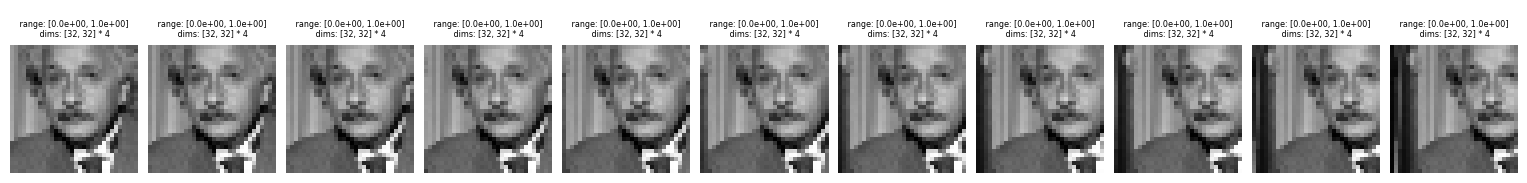

In [2]:
image_size = 64
einstein = po.load_images('../data/256/einstein.pgm')
einstein = po.tools.conv.blur_downsample(einstein, step=(4,4))
vid = po.tools.translation_sequence(einstein[0])
from torchvision.transforms.functional import center_crop
vid = center_crop(vid, image_size // 2)
vid = po.tools.rescale(vid, 0, 1)

imgA = vid[0:1]
imgB = vid[-1:]

pt.image_stats(to_numpy(imgA))
pt.image_stats(to_numpy(imgB))
print(imgA.shape)
print(vid.shape)

# convention: full name for numpy arrays, short hands for torch tensors
video = to_numpy(vid).squeeze()
print(video.shape)
# pt.animshow(video, zoom=4)
pt.imshow(list(video.squeeze()), zoom=4);

In [3]:
import torch.fft
class Fourier(nn.Module):
    def __init__(self, representation = 'amp'):
        super().__init__()
        self.representation = representation
        
    def spectrum(self, x):
        return torch.fft.rfftn(x, dim=(2, 3))

    def forward(self, x):
        if self.representation == 'amp':
            return torch.abs(self.spectrum(x))
        elif self.representation == 'phase':
            return torch.angle(self.spectrum(x))
        elif self.representation == 'rectangular':
            return self.spectrum(x)
        elif self.representation == 'polar':
            return torch.cat((torch.abs(self.spectrum(x)),
                              torch.angle(self.spectrum(x))),
                             dim=1)

model = Fourier('amp')
# model = Fourier('polar') # note: need pytorch>=1.8 to take gradients through torch.angle 

In [4]:
n_steps = len(video)-1
moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='bridge')
moog.synthesize(max_iter=500, learning_rate=.01, lmbda=.1)

100%|██████████| 500/500 [00:01<00:00, 278.54it/s, loss=9.6412e+01, gradient norm=2.0321e+01, lr=0.01]


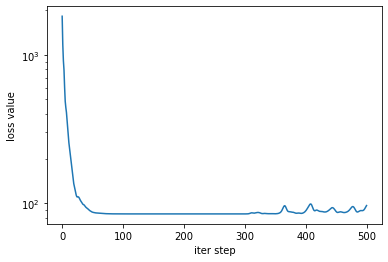

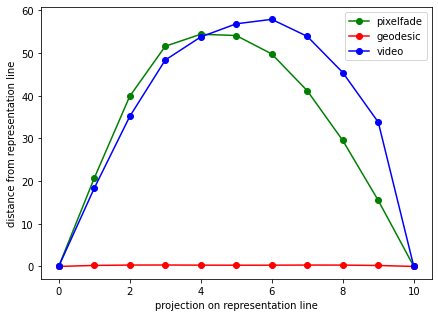

In [5]:
moog.plot_loss();
moog.plot_distance_from_line(vid);

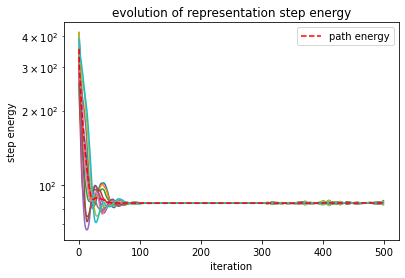

In [6]:
plt.plot([po.to_numpy(e) for e in moog.step_energy]);
plt.plot([e.mean() for e in moog.step_energy], 'r--', label='path energy')
plt.legend()
plt.title('evolution of representation step energy')
plt.ylabel('step energy')
plt.xlabel('iteration')
plt.yscale('log')
plt.show()

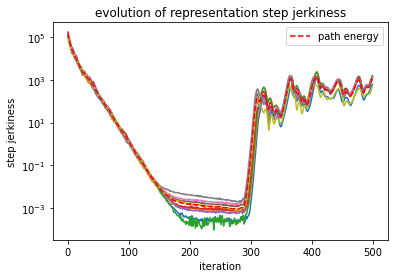

In [7]:
plt.plot([po.to_numpy(j) for j in moog.step_jerkiness]);
plt.plot([j.mean() for j in moog.step_jerkiness], 'r--', label='path energy');
plt.legend()
plt.title('evolution of representation step jerkiness')
plt.ylabel('step jerkiness')
plt.xlabel('iteration')
plt.yscale('log')
plt.show()

In [8]:
try:
    moog.animate_distance_from_line(vid).save("../logs/distfromline_fourieramp_translation.mp4")
except:
    print('generating the animation takes time, there we dont do it by default')
    
    plt.plot(po.to_numpy(torch.stack(moog.dist_from_line, 0)[:, 1:-1]))

    plt.title('evolution of distance from representation line')
    plt.ylabel('distance from representation line')
    plt.xlabel('iteration step')
    # plt.yscale('log')
    plt.show()

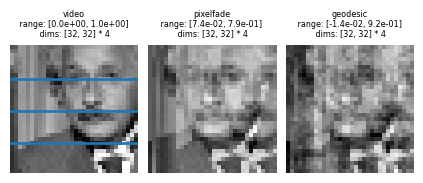

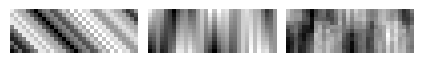

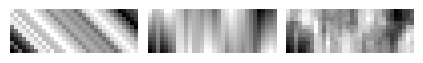

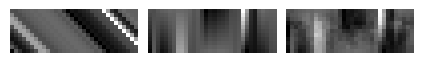

In [9]:
pixelfade = to_numpy(moog.pixelfade.squeeze())
geodesic = to_numpy(moog.geodesic.squeeze())
fig = pt.imshow([video[5], pixelfade[5], geodesic[5]],
          title=['video', 'pixelfade', 'geodesic'],
          col_wrap=3, zoom=4);

size = geodesic.shape[-1]
h, m , l = (size//2 + size//4, size//2, size//2 - size//4)

# for a in fig.get_axes()[0]:
a = fig.get_axes()[0]
for line in (h, m, l):
    a.axhline(line, lw=2)


pt.imshow([video[:,l], pixelfade[:,l], geodesic[:,l]],
          title=None, col_wrap=3, zoom=4);
pt.imshow([video[:,m], pixelfade[:,m], geodesic[:,m]],
          title=None, col_wrap=3, zoom=4);
pt.imshow([video[:,h], pixelfade[:,h], geodesic[:,h]],
          title=None, col_wrap=3, zoom=4);

### Physiologically inspired models

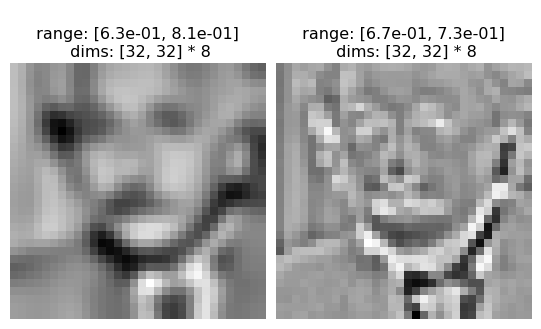

In [10]:
model = po.simul.FrontEnd()
po.imshow(model(imgA), zoom=8);
# po.imshow(model.conv.weight, zoom=28, vrange='auto0');

In [11]:
n_steps = 10

moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='straight')

print('shape trainable param', '# trainable param')
#  sum(p.numel() for p in moog.parameters())
[p.shape for p in moog.parameters() if p.requires_grad], sum(p.numel() for p in moog.parameters() if p.requires_grad)

shape trainable param # trainable param


([torch.Size([9, 1024]),
  torch.Size([1, 2, 1, 1]),
  torch.Size([1, 2, 1, 1]),
  torch.Size([2, 1, 31, 31]),
  torch.Size([2, 1, 31, 31]),
  torch.Size([2, 1, 31, 31])],
 14986)

In [12]:
try:
    from adabelief_pytorch import AdaBelief
    import adabelief_pytorch
    print(adabelief_pytorch.__version__)
    optimizer = AdaBelief(moog.parameters(), lr=0.01, eps=1e-16, betas=(0.9,0.999),
                          weight_decouple=True, rectify=False, print_change_log=False)
except:
    optimizer = torch.optim.RMSprop(moog.parameters(), lr=0.01, alpha=0.99, eps=1e-08,
                                weight_decay=0, momentum=0, centered=False)

moog.synthesize(optimizer=optimizer, lmbda=0.05)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.2.0
Weight decoupling enabled in AdaBelief


100%|██████████| 1000/1000 [03:02<00:00,  5.48it/s, loss=4.0283e-07, gradient norm=1.5178e-07, lr=0.01]


In [13]:
# TODO ideas to deal with unstable optimization: running into NaN
    # gradient clipping
    # control bridge
    # init images
    # logspace 

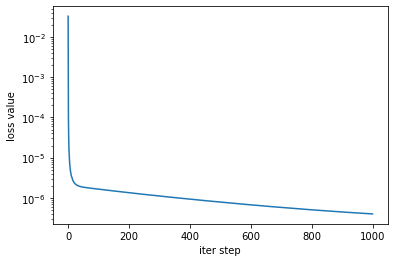

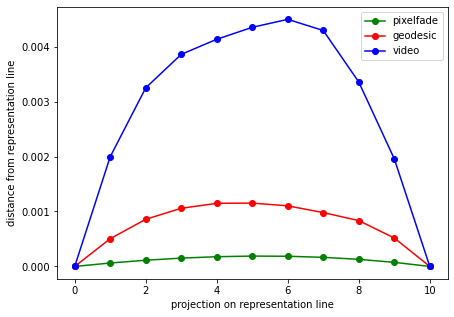

In [14]:
moog.plot_loss()
moog.plot_distance_from_line(vid);

In [15]:
try:
    moog.animate_distance_from_line(vid).save("../logs/distfromline_frontend_translation.mp4")
except:
    print('generating the animation takes time, there we dont do it by default')

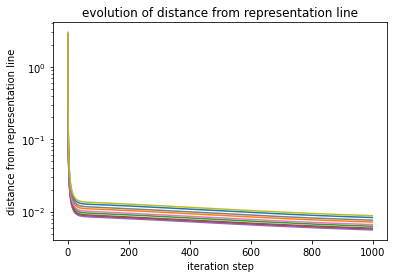

In [16]:
plt.plot(po.to_numpy(torch.stack(moog.dist_from_line, 0)[:, 1:-1]))

plt.title('evolution of distance from representation line')
plt.ylabel('distance from representation line')
plt.xlabel('iteration step')
plt.yscale('log')
plt.show()

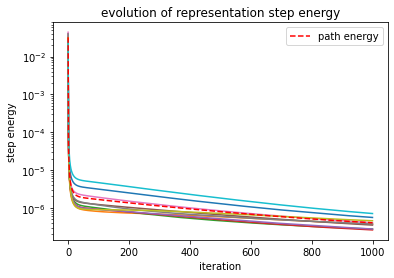

In [17]:
plt.plot([po.to_numpy(e) for e in moog.step_energy]);
plt.plot([e.mean() for e in moog.step_energy], 'r--', label='path energy')
plt.legend()
plt.title('evolution of representation step energy')
plt.ylabel('step energy')
plt.xlabel('iteration')
plt.yscale('log')
plt.show()

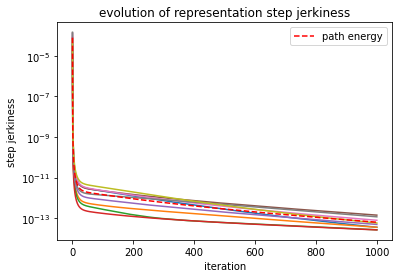

In [18]:
plt.plot([po.to_numpy(j) for j in moog.step_jerkiness]);
plt.plot([j.mean() for j in moog.step_jerkiness], 'r--', label='path energy');
plt.legend()
plt.title('evolution of representation step jerkiness')
plt.ylabel('step jerkiness')
plt.xlabel('iteration')
plt.yscale('log')
plt.show()

In [19]:
# pt.imshow(list(moog.yA[0]), col_wrap=4);
# pt.imshow(list(moog.yB[0]), col_wrap=4);

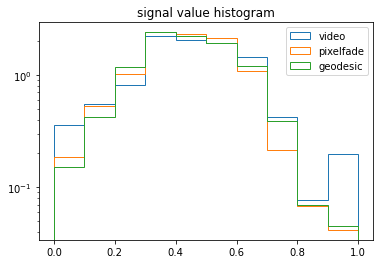

In [20]:
geodesic  = po.to_numpy(moog.geodesic).squeeze()
pixelfade = po.to_numpy(moog.pixelfade).squeeze()
assert geodesic.shape == pixelfade.shape

# checking that the range constraint is met
plt.hist(video.flatten(), histtype='step', density=True, label='video')
plt.hist(pixelfade.flatten(), histtype='step', density=True, label='pixelfade')
plt.hist(geodesic.flatten(), histtype='step', density=True, label='geodesic');
plt.yscale('log')
plt.title('signal value histogram')
plt.legend(loc=1)
plt.show()

geodesic
diff
pixelfade


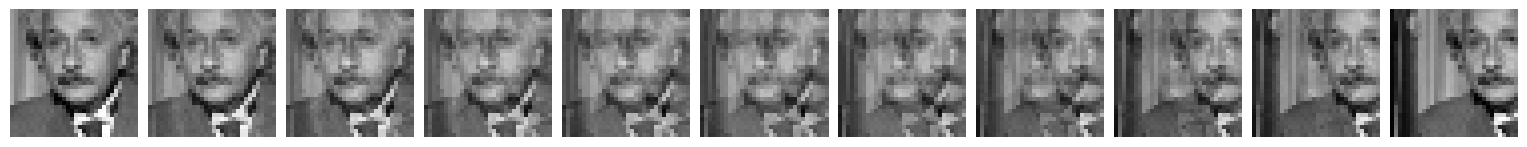

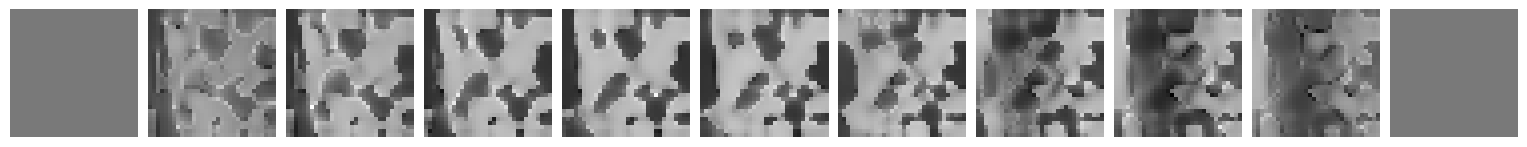

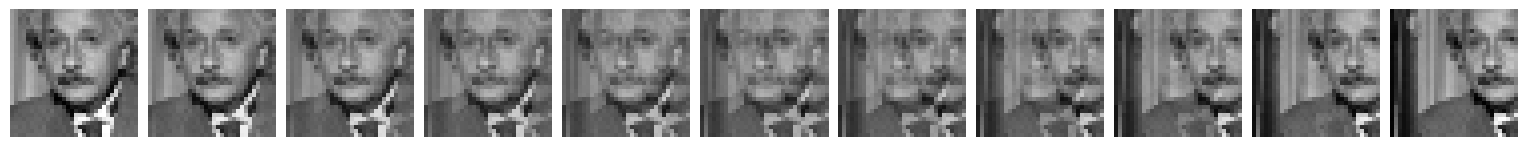

In [21]:
print('geodesic')
pt.imshow(list(geodesic), vrange='auto1', title=None, zoom=4);
print('diff')
pt.imshow(list(geodesic - pixelfade), vrange='auto1', title=None, zoom=4);
print('pixelfade')
pt.imshow(list(pixelfade), vrange='auto1', title=None, zoom=4);

## Texture interpolation

Image statistics:
  Range: [0.011765, 0.960784]
  Mean: 0.429482,  Stdev: 0.233141,  Kurtosis: 1.572914
Image statistics:
  Range: [0.007843, 1.000000]
  Mean: 0.392800,  Stdev: 0.255207,  Kurtosis: 3.235565


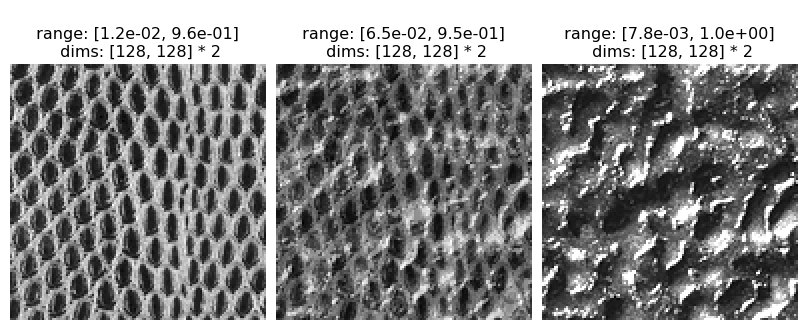

In [22]:
path = '../data/256/'
nameA = 'reptil_skin'
nameB = 'metal'

imageA = plt.imread(path + nameA + '.pgm') / 255.
imageB = plt.imread(path + nameB + '.pgm') / 255.

c = 64
imageA = imageA[c:-c, c:-c]
imageB = imageB[c:-c, c:-c]
pt.image_stats(imageA)
pt.image_stats(imageB)

imgSize = imageA.shape[0]
pt.imshow([imageA, (imageA + imageB)/2, imageB], vrange='indep1', zoom=2);

In [23]:
imgA = torch.tensor(imageA, dtype=dtype).unsqueeze(0).unsqueeze(0)
imgB = torch.tensor(imageB, dtype=dtype).unsqueeze(0).unsqueeze(0)

print(imgA.shape)
from plenoptic.tools.straightness import make_straight_line
n_steps = 11
video = make_straight_line(imgA, imgB, n_steps)
print(video.shape)
pt.image_stats(po.to_numpy(video).squeeze())
pt.animshow(po.to_numpy(video).squeeze(), zoom=2)

torch.Size([1, 1, 128, 128])
torch.Size([12, 1, 128, 128])
Image statistics:
  Range: [0.007843, 1.000000]
  Mean: 0.411141,  Stdev: 0.204012,  Kurtosis: 2.655251


In [24]:
# TODO develop hierarchy of texture models 
# model = po.simul.Spectral(image_size=imgB.shape[-2:], n_scale='auto')
# CoupledSpectrum
# PolarPyr
# model = po.simul.models.PortillaSimoncelli()
# texture statistics

# n_steps = len(video)-1
# moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='bridge')
# moog.synthesize(max_iter=500, learning_rate=.01, lmbda=.1)